In [6]:
%%writefile mm.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

int  *A;
int  *B; 
int  *C;
int size;
int num_threads;

void writeResultsToFile(int size, double msft, double mpft, double mpcrft, double speedup) {
    FILE *output_file = fopen("output.txt", "a");
    if (output_file == NULL) {
        perror("Erro ao abrir o arquivo de saída");
        return;
    } 

    fprintf(output_file, "%d %lf %lf %lf %f\n", size, msft, mpft, mpcrft, speedup);
    if(size == 1000) fprintf(output_file, "\n");

    fclose(output_file);
}

void initializeMatrix(int *matrix, int size)
{
  for(int i = 0; i < size; i++)
    for(int j = 0; j < size; j++)
      matrix[i * size + j] = rand() % (10 - 1) * 1;
}

void multiply_sequential(){
  int i, j, k;
  for(i = 0; i < size; i++)
    for(j = 0; j < size; j++)
      for(k = 0; k < size; k++)
        C[i * size + j] += A[i * size + k] * B[k * size + j];
}

void multiply_parallel(){
  int i, j, k;
  #pragma omp parallel for private(i, j, k)
  for(i = 0; i < size; i++){
    for(j = 0; j < size; j++){
      if (i == 0 && j == 0) num_threads = omp_get_num_threads();
      for(k = 0; k < size; k++)
        C[i * size + j] = A[i * size + k] * B[k * size + j];
    }
  } 
}

void multiply_parallel_collapse_reduction(){
  int i, j, k;
  #pragma omp parallel for collapse(2) private(i, j, k)
  for(i = 0; i < size; i++){
    for(j = 0; j < size; j++){
      if (i == 0 && j == 0) num_threads = omp_get_num_threads();
      int ans = 0;
    #pragma omp simd reduction(+ : ans)
      for(k = 0; k < size; k++){
        ans += A[i * size + k] * B[k * size + j];
      }
      C[i * size + j] = ans;
    }
  } 
}

int main (int argc, char **argv)
{
  size = atoi(argv[1]);  
  int i, j, k;
  double st1, st2, mpt1, mpt2, mpcrt1, mpcrt2;

  A = (int *) malloc (sizeof(int)*size*size);
  B = (int *) malloc (sizeof(int)*size*size);
  C = (int *) malloc (sizeof(int)*size*size);

  initializeMatrix(A, size);
  initializeMatrix(B, size);

  // Sequential
  st1 = omp_get_wtime();
  multiply_sequential();
  st2 = omp_get_wtime();
  
  // Parallel
  mpt1 = omp_get_wtime();
  multiply_parallel();
  mpt2 = omp_get_wtime();

  // Parallel collapse reduction
  mpcrt1 = omp_get_wtime();
  multiply_parallel_collapse_reduction();
  mpcrt2 = omp_get_wtime();
  
  double msft = st2-st1; // Sequencial final time
  double mpft = mpt2-mpt1; // Parallel final time
  double mpcrft = mpcrt2-mpcrt1; // Parallel collapse reduction final time

  double speedup = msft/mpcrft;

  //printf("Size: %d\tMSFT: %f\tMPFT: %f\tMPCRFT: %f\tSpeedUp: %f\tNum Threads: %d\n", size, msft, mpft, mpcrft, speedup, num_threads);

  int num_results = 4;

  writeResultsToFile(size, msft, mpft, mpcrft, speedup);

  return 0;
}

Writing mm.c


### Run the Code

In [7]:
!gcc mm.c -o mm -fopenmp

### Performance Analysis

In [8]:
%%writefile script.sh
#!/bin/sh

for ((i=2; i<=64; i*=2))
do
  echo "Number of threads:" $i "=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-="  
  for ((j=200; j<=1000; j+=200))
  do
    OMP_NUM_THREADS="$i" ./mm "$j"
  done
  echo 
done

Writing script.sh


In [9]:
!bash script.sh 

Number of threads: 2 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Number of threads: 4 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Number of threads: 8 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
^C


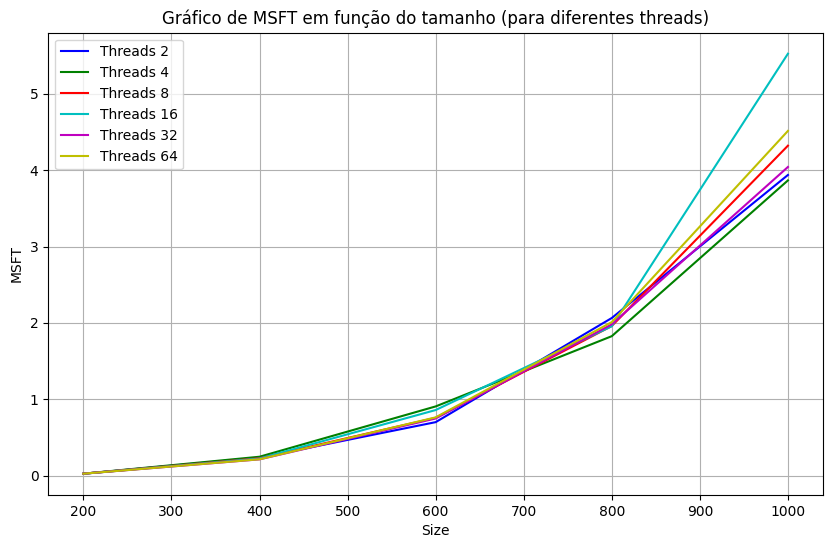

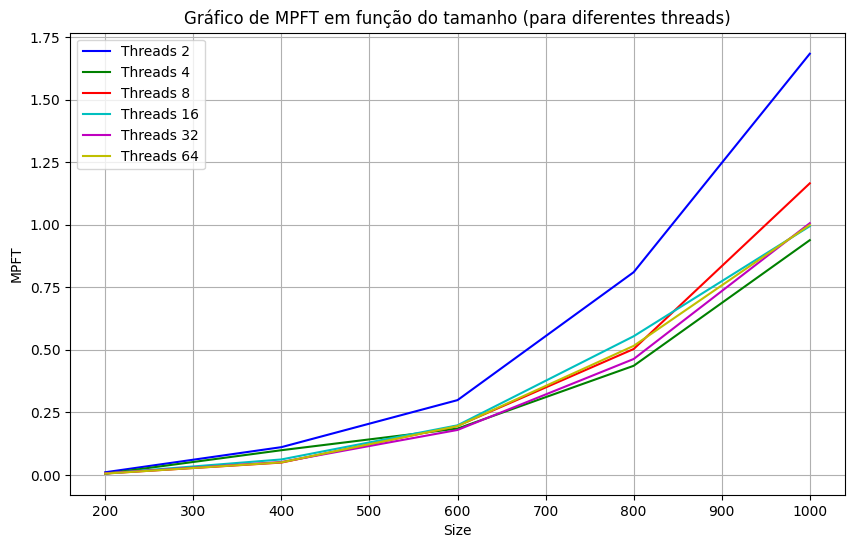

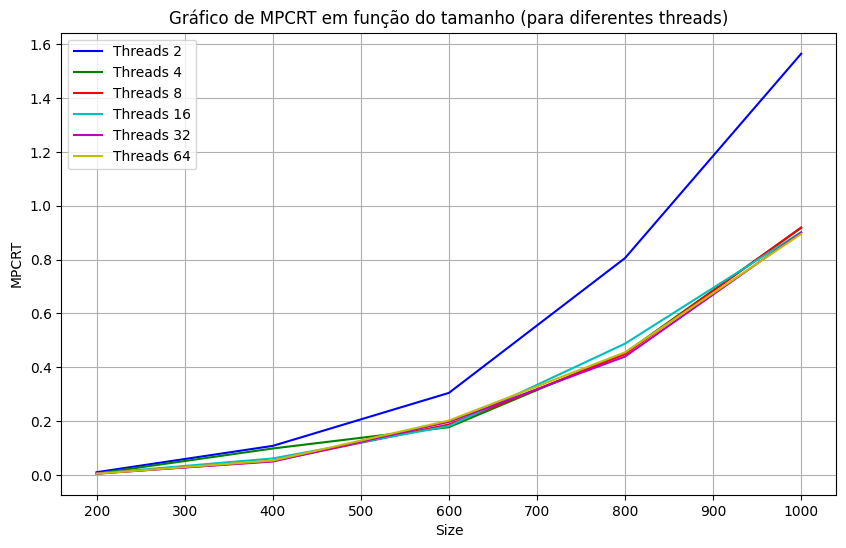

In [5]:
import matplotlib.pyplot as plt

# Função para plotar os gráficos
def plot_graph(x_data, y_data, title, y_label, legend_labels):
    plt.figure(figsize=(10, 6))
    for i in range(len(x_data)):
        plt.plot(x_data[i], y_data[i], label=legend_labels[i], color=colors[i])

    plt.xlabel('Size')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Listas para armazenar os dados
sizes = []
msfts = []
mpfts = []
mpcrts = []

# Lista de cores para as linhas
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Lista de threads para a legenda
threads = [2, 4, 8, 16, 32, 64]

# Abrir o arquivo e ler os dados
with open('output.txt', 'r') as file:
    lines = file.readlines()
    current_data = []  # Armazena os dados do bloco atual
    for line in lines:
        if line.strip():  # Verifica se a linha não está vazia
            values = line.split()
            size = int(values[0])
            msft = float(values[1])
            mpft = float(values[2])
            mpcrt = float(values[3])
            current_data.append((size, msft, mpft, mpcrt))
        else:
            # Nova linha em branco indica o início de um novo bloco
            sizes.append([data[0] for data in current_data])
            msfts.append([data[1] for data in current_data])
            mpfts.append([data[2] for data in current_data])
            mpcrts.append([data[3] for data in current_data])
            current_data = []

# Plotar o gráfico para MSFT
plot_graph(sizes, msfts, 'Gráfico de MSFT em função do tamanho (para diferentes threads)', 'MSFT', [f'Threads {thread}' for thread in threads])

# Plotar o gráfico para MPFT
plot_graph(sizes, mpfts, 'Gráfico de MPFT em função do tamanho (para diferentes threads)', 'MPFT', [f'Threads {thread}' for thread in threads])

# Plotar o gráfico para MPCRT
plot_graph(sizes, mpcrts, 'Gráfico de MPCRT em função do tamanho (para diferentes threads)', 'MPCRT', [f'Threads {thread}' for thread in threads])


# Questions and Answers:

## Question 1:
**What is the behavior of execution time and speedup as the problem size varies? (Present the solution with tabular and graphical data).**

The execution time and speedup vary as the problem size changes. Some expected behaviors also occur, such as for a smaller problem and a larger number of threads, the speedup is reduced, as parallelizing the code in these circumstances proves to be ineffective.

## Question 2:
**What is the optimal number of threads for the best parallel solution?**

The optimal number of threads is 64.

## `Asynchronous Task`

In [ ]:
%%writefile asyncTaskOpenMP.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define SIZE_MATRIX 10

int main(int argc, char **argv)
{
  int n = atoi(argv[1]);
  int block_size = atoi(argv[2]);
  int matrix[SIZE_MATRIX][SIZE_MATRIX], k1 = 10, k2 = 20, k3 = 30, k4 = 40, k5 = 50;
  int i, j, row, column;

  for(i = 0; i < n; i++)
  {
    for(j = 0; j < n; j++)
    {
      matrix[i][j] = 5;
      printf("%d\t", matrix[i][j]);
    }
    printf("\n");
  }

  printf("\n\n");

  omp_set_num_threads(5);

  #pragma omp parallel private(row, column)
  {
    int id = omp_get_thread_num();

    if(id == 0)
    {
      for(row = 0; row < n; row++)
        for(column = block_size*id; column < block_size; column++)
          matrix[row][column] *= k1;
    }

    if(id == 1)
    {
      for(row = 0; row < n; row++)
        for(column = block_size*id; column < 2 * block_size; column++)
          matrix[row][column] *= k2;
    }

    if(id == 2)
    {
      for(row = 0; row < n; row++)
        for(column = block_size*id; column < 3 * block_size; column++)
          matrix[row][column] *= k3;
    }

    if(id == 3)
    {
      for(row = 0; row < n; row++)
        for(column = block_size*id; column < 4 * block_size; column++)
          matrix[row][column] *= k4;
    }

    if(id == 4)
    {
      for(row = 0; row < n; row++)
        for(column = block_size*id; column < 5 * block_size; column++)
          matrix[row][column] *= k5;
    }
  
  }

  for(i = 0; i < n; i++)
  {
    for(j = 0; j < n; j++)
      printf("%d\t", matrix[i][j]);
    printf("\n");
  }

  return 0;
}

### Run the Code

In [ ]:
!gcc asyncTaskOpenMP.c -o asyncTaskOpenMP -fopenmp

In [ ]:
!./asyncTaskOpenMP 10 2

# Questions and Answers:

## Question 1:
**What does the code do from the compilation and execution of the previous code?**

The code aims to divide the matrix into parts, where each thread will be responsible for performing operations on these parts independently.

## Question 2:
**How would it be possible to extend the code so that the five threads perform asynchronous tasks?**

We only need to adjust the range that each thread will follow and adjust the number of "if" statements to cover all possible IDs.


## References

M. Boratto. Hands-On Supercomputing with Parallel Computing. Available: https://github.com/muriloboratto/Hands-On-Supercomputing-with-Parallel-Computing. 2022.

B. Chapman, G. Jost and R. Pas. Using OpenMP: Portable Shared Memory Parallel Programming. The MIT Press, 2007, USA.